In [166]:
import numpy as np
import pandas as pd


In [310]:
# read the data set
df_radiology = pd.read_csv('data/df_radiology.csv', encoding = "ISO-8859-1")
df_encounter = pd.read_csv('data/df_encounter.csv', encoding = "ISO-8859-1")
df_outcome = pd.read_csv('data/df_outcome.csv', encoding = "ISO-8859-1")
df_echo = pd.read_csv('data/df_echo.csv', encoding = "ISO-8859-1")


In [168]:
def merge_encounter_radiology(df_encounter, df_radiology, cutoff_OrderTime=12, cutoff_ED_Disp=12):
    # generate a new df_CT dataframe
    # 1. focus on 'CT ANGIOGRAM' only
    # 2. order time within 12h
    # 3. keep only the first order for the outliers (only one data point that has 2 orders)

    df_CT = df_radiology[df_radiology['NAME'].apply(lambda x: x.startswith('CT AN'))]
    df_CT = df_CT[df_CT['ORDER_TIME_DIFFSEC'] <= cutoff_OrderTime*3600]
    df_CT = df_CT.drop_duplicates('HSP_ENC', keep='first')

    # combine df_encounter and df_CT based on 'HSP_ENC' id
    df_encounter = df_encounter[df_encounter['ED_DISP_TIME_DIFFSEC']<=cutoff_ED_Disp*3600]
    df_enc_CT = pd.merge(df_encounter, df_CT, how='left', on='HSP_ENC')
    df_enc_CT.set_index('HSP_ENC', inplace=True)
    
    return df_enc_CT


In [169]:
def expand_outcome(dfOutcome):
    ## Outcome expansion   
    
    # Drop any outcomes after 48 hr
    dfOutcome = dfOutcome[dfOutcome['ORDER_TIME_DIFFSEC']<48*60*60]
    
    # Create columns for each unique outcome
    lsExpandedOutcomeCols = []
    lsOutcomeColsToRetain = dfOutcome.columns[2:].tolist()
    lsUniqueOutcomes = dfOutcome['name_gen'].value_counts().index.tolist()
    for strOutcome in lsUniqueOutcomes:
        lsExpandedOutcomeCols += [strCol + '_' + strOutcome for strCol in lsOutcomeColsToRetain]

    dfExpandedOutcome = pd.DataFrame(columns=lsExpandedOutcomeCols+['PATIENT_ID'])
    dfExpandedOutcome['HSP_ENC'] = dfOutcome['HSP_ENC'].value_counts().index
    dfExpandedOutcome = dfExpandedOutcome.set_index('HSP_ENC')

    for nEnc in dfOutcome['HSP_ENC'].value_counts().index:
        for nIdx in dfOutcome[dfOutcome['HSP_ENC']==nEnc].index:
            lsTempCols = [strCol + '_' + dfOutcome.at[nIdx, 'name_gen'] for strCol in lsOutcomeColsToRetain]
            lsTempCols.append('PATIENT_ID')
            dfExpandedOutcome.loc[nEnc, lsTempCols] = dfOutcome.loc[nIdx, lsOutcomeColsToRetain+['PATIENT_ID']].values

    # Create boolean column for order time < 48 hrs for any outcome
    lsOrderTimeCols = [strCol for strCol in dfExpandedOutcome.columns if 'ORDER_TIME' in strCol]

    dfExpandedOutcome['b48hr'] = np.zeros(dfExpandedOutcome.shape[0])
    for nEnc in dfExpandedOutcome.index:
        for nVal in dfExpandedOutcome.loc[nEnc, lsOrderTimeCols].values:
            if nVal < 172800:
                dfExpandedOutcome.at[nEnc, 'b48hr'] = 1

    # Column for minimum order time from all outcomes
    dfExpandedOutcome['MinOrderTime'] = dfExpandedOutcome.loc[:, lsOrderTimeCols].min(axis=1)
    dfExpandedOutcome = dfExpandedOutcome.sort_values('MinOrderTime')
    
    return dfExpandedOutcome


def compile_echo(dfEcho):    
    # Keep only 12 hr echos
    dfEcho = dfEcho[dfEcho['ORDER_INST_DIFFSEC'] < 12*60*60]

    # Add all narratives together
    lsUniqueEchoEnc = dfEcho['HSP_ENC'].value_counts().index.tolist()

    lsEchoCols = dfEcho.columns.tolist()
    lsEchoCols.remove('new_line')
    lsEchoCols.remove('NARRATIVE')
    dfCompiledEcho = pd.DataFrame(columns=lsEchoCols)
    dfCompiledEcho['HSP_ENC'] = lsUniqueEchoEnc
    dfCompiledEcho = dfCompiledEcho.set_index('HSP_ENC')
    lsEchoCols.remove('HSP_ENC')

    lsCompiledNarratives = []
    for nEnc in lsUniqueEchoEnc:
        lsUniqueEchoOrderId = dfEcho[dfEcho['HSP_ENC']==nEnc]['ORDER_PROC_ID'].value_counts().index.tolist()
        #if len(lsUniqueEchoOrderId)>1:
            #print(nEnc)
        nFirstEchoOrderId = lsUniqueEchoOrderId[0] # Keep first one only
        
        # Compile echo data
        strCompiled = dfEcho[dfEcho['ORDER_PROC_ID']==nFirstEchoOrderId]['NARRATIVE'].str.cat(sep=' ')
        dfCompiledEcho.loc[nEnc, lsEchoCols] = dfEcho[dfEcho['ORDER_PROC_ID']==nFirstEchoOrderId][lsEchoCols].iloc[0]
        lsCompiledNarratives.append(strCompiled)
    dfCompiledEcho['NARRATIVE_compiled'] = lsCompiledNarratives

    # Keep only 12 hr echos
    dfCompiledEcho = dfCompiledEcho[dfCompiledEcho['ORDER_INST_DIFFSEC'] < 12*60*60]
    
    return dfCompiledEcho

def get_merge_dfs(dfOutcome, dfEcho, dfEncounter):
    dfExpandedOutcome = expand_outcome(dfOutcome)
    dfCompiledEcho = compile_echo(dfEcho)
    dfEncounter = dfEncounter.set_index('HSP_ENC')
    
    dfMerged = dfEncounter.merge(dfExpandedOutcome, how='left', on='HSP_ENC')
    dfMerged = dfMerged.merge(dfCompiledEcho, how='left', on='HSP_ENC')
    
    return dfMerged


In [170]:
# read each dataset
df_enc_echo_outcome = get_merge_dfs(df_outcome, df_echo, df_encounter)
df_enc_CT = merge_encounter_radiology(df_encounter, df_radiology)

# clean the dataset
df_cleaned = df_enc_echo_outcome.merge(df_enc_CT, how='left', on='HSP_ENC')

# raw column names
name_gen = []
for i in df_cleaned.columns.values:
    if i.startswith('name_gen') or i.startswith('NARR'):
        name_gen.append(i)
name_gen = sorted(name_gen) + ['b48hr']

# rename the column names
df_cleaned = df_cleaned[name_gen]
new_columns = ['CT', 'Echo', 'CPR', 'DEATH', 'INTUBATION', 'PPV', 'THROMBOLYSIS', 'THROMBOLYSIS_PROC', 'VASOPRESSORS', 'B48hr']
df_cleaned.columns = new_columns

# fill Nan
df_cleaned['CT'].fillna('No_CT', inplace=True)
df_cleaned['Echo'].fillna('No_Echo', inplace=True)
df_cleaned.fillna(0, inplace=True)

# convert to 1
map_dict = {'DEATH': 1, 
            'INTUBATION': 1,
            'PPV': 1,
            'THROMBOLYSIS': 1,
            'THROMBOLYSIS_PROC': 1,
            'VASOPRESSORS': 1,
            0:0}
for col in ['DEATH', 'INTUBATION', 'PPV', 'THROMBOLYSIS', 'THROMBOLYSIS_PROC', 'VASOPRESSORS']:
    df_cleaned[col] = df_cleaned[col].map(map_dict)

    

In [190]:
#df_cleaned.to_csv('cleaned_ct_echo_outcome.csv')
df_cleaned.head()

,CT,Echo,CPR,DEATH,INTUBATION,PPV,THROMBOLYSIS,THROMBOLYSIS_PROC,VASOPRESSORS,B48hr
HSP_ENC,,,,,,,,,,
260755660,EXAM: CT ANGIOGRAPHY CHEST PULMONARY ARTERIES ...,STUDY DATE: 04/08/2017 * REASON FOR STUDY: Sho...,0,0,0,0,0,0,0,0.0
192470437,No_CT,No_Echo,0,0,0,0,0,0,1,1.0
258754156,No_CT,No_Echo,0,0,0,0,0,0,0,0.0
306050512,EXAM: CT ANGIOGRAPHY CHEST PULMONARY ARTERIES ...,STUDY DATE: 06/25/2018 * REASON FOR STUDY: Tac...,0,0,0,0,1,1,0,1.0
163297609,No_CT,No_Echo,0,0,0,0,0,0,0,0.0


In [171]:
X = pd.DataFrame()
X['CT_Echo'] = df_cleaned.apply(lambda x: x['CT']+' '+x['Echo'], axis=1)
X['B48hr'] = df_cleaned['B48hr']
X 

,CT_Echo,B48hr
HSP_ENC,,
260755660,EXAM: CT ANGIOGRAPHY CHEST PULMONARY ARTERIES ...,0.0
192470437,No_CT No_Echo,1.0
258754156,No_CT No_Echo,0.0
306050512,EXAM: CT ANGIOGRAPHY CHEST PULMONARY ARTERIES ...,1.0
163297609,No_CT No_Echo,0.0
...,...,...
178796884,No_CT No_Echo,0.0
1829587297,No_CT No_Echo,1.0
1802565292,EXAM: CT ANGIOGRAPHY CHEST PULMONARY ARTERIES ...,0.0


In [172]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X['CT_Echo'], 
                                                    X['B48hr'], 
                                                    random_state=0)

In [188]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve, auc

#vect = CountVectorizer().fit(X_train)
#vect = TfidfVectorizer().fit(X_train)
vect = TfidfVectorizer(min_df=5, ngram_range=(2,10)).fit(X_train)

#m = MultinomialNB(alpha=0.1).fit(vect.transform(X_train), y_train)
#m = LogisticRegression(C=100.).fit(vect.transform(X_train), y_train)
#m = SVC(C=10000.).fit(vect.transform(X_train), y_train)

#pred = m.predict(vect.transform(X_test))
#result = roc_auc_score(y_test, pred)

#result



m = LogisticRegression().fit(vect.transform(X_train), y_train)
y_scores_m = m.decision_function(vect.transform(X_test))
y_proba_m = [i[1] for i in m.predict_proba(vect.transform(X_test))]

precision, recall, thresholds = precision_recall_curve(y_test, y_proba_m)
fpr, tpr, _ = roc_curve(y_test, y_proba_m)
roc_auc = auc(fpr, tpr)
roc_auc

/home/plian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.6556361239288068

/home/plian/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':


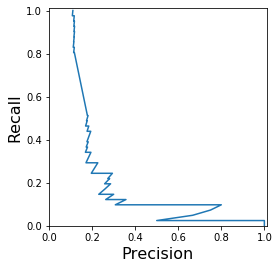

/home/plian/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


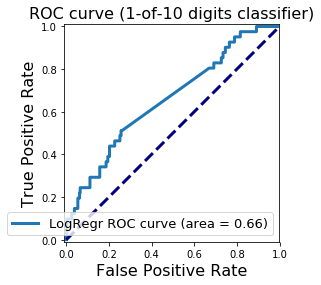

In [189]:
import matplotlib.pyplot as plt
#print(precision, recall, thresholds)
#print(fpr, tpr, _ )

plt.figure()
plt.xlim([0.0, 1.01])
plt.ylim([0.0, 1.01])
plt.plot(precision, recall, label='Precision-Recall Curve')
#plt.plot(closest_zero_p, closest_zero_r, 'o', markersize = 12, fillstyle = 'none', c='r', mew=3)
plt.xlabel('Precision', fontsize=16)
plt.ylabel('Recall', fontsize=16)
plt.axes().set_aspect('equal')
plt.show()

plt.figure()
plt.xlim([-0.01, 1.00])
plt.ylim([-0.01, 1.01])
plt.plot(fpr, tpr, lw=3, label='LogRegr ROC curve (area = {:0.2f})'.format(roc_auc))
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve (1-of-10 digits classifier)', fontsize=16)
plt.legend(loc='lower right', fontsize=13)
plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
plt.axes().set_aspect('equal')
plt.show()

In [186]:
roc_auc

0.6556361239288068

In [317]:
def preproc_labeled_echo(dfEchoLabeled):
    # Changing mlid to mild
    dfEchoLabeled['function'] = dfEchoLabeled['function'].replace('mlid', 'mild')
    dfEchoLabeled['dilation'] = dfEchoLabeled['dilation'].replace('mlid', 'mild')
    
    # na to 0, mild to 1, moderate to 2, severe to 3
    dictReplace = {'mild':1, 'moderate':2, 'severe':3}
    dfEchoLabeled['function'] = dfEchoLabeled['function'].fillna(0)
    dfEchoLabeled['function'] = dfEchoLabeled['function'].replace(dictReplace)

    dfEchoLabeled['dilation'] = dfEchoLabeled['dilation'].fillna(0)
    dfEchoLabeled['dilation'] = dfEchoLabeled['dilation'].replace(dictReplace)
    
    return dfEchoLabeled


def merge_labeled_echo(dfMerged, dfEchoLabeled):
    """
    Parse labeled echo data to keep matching enc, order_proc_id
    If multiple rows per enc and order id, keep max bc this 
    represents different line of report
    """
    srsIsNullNarrative = dfMerged['NARRATIVE_compiled'].isnull()
    for nEnc in dfMerged.index:
        nOrder = dfMerged.at[nEnc, 'ORDER_PROC_ID']
        dfTemp = dfEchoLabeled[dfEchoLabeled['HSP_ENC']==nEnc]
        dfTemp = dfTemp[dfTemp['ORDER_PROC_ID']==nOrder]
        if dfTemp.shape[0] > 0:    
            dfMerged.at[nEnc, 'echo_dilation'] = dfTemp['dilation'].max()
            dfMerged.at[nEnc, 'echo_function'] = dfTemp['function'].max()
        elif not srsIsNullNarrative[nEnc]:
            dfMerged.at[nEnc, 'echo_dilation'] = 0
            dfMerged.at[nEnc, 'echo_function'] = 0
    
    return dfMerged




df_echo_label = pd.read_csv('data/echo_tag.csv', encoding='ISO-8859-1')


dfEchoLabeled = preproc_labeled_echo(df_echo_label)
dfMerged = merge_labeled_echo(df_enc_echo_outcome, dfEchoLabeled)

#dfMerged.head()
df_new_features_echo_tags = dfMerged[['echo_dilation','echo_function']]



In [319]:
dfMerged.head()

,PATIENT_ID_x,ED_EPISODE_ID,ED_DISP,DISCH_DISP,ADT_ARRIVAL_TIME_DIFFSEC,ED_DISP_TIME_DIFFSEC,HOSP_DISCH_TIME_DIFFSEC,ADMIT_SOURCE,ADT_PAT_CLASS,HOSP_SERVICE,...,PATIENT_ID,ORDER_PROC_ID,NAME,ORDER_INST_DIFFSEC,PROC_START_TIME_DIFFSEC,RESULT_TIME_DIFFSEC,ECHO_TYPE,NARRATIVE_compiled,echo_dilation,echo_function
HSP_ENC,,,,,,,,,,,,,,,,,,,,,
260755660,1305,34382396,Admitted,To Home Or Self Care,-420,10500,627600,Home & Outside Location,Inpatient,Pulmonary,...,1305,330967554,CV ECHO,27060,27060,105180,echo_old,STUDY DATE: 04/08/2017 * REASON FOR STUDY: Sho...,0.0,0.0
192470437,1261,27636517,Admitted,To Home With Home Health,-120,9120,516300,Home & Outside Location,Inpatient,Cardiology,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
258754156,785,34189980,Admitted,Expired,0,40200,899640,Home & Outside Location,Inpatient,Cardiology,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
306050512,504,38409274,Admitted,To Home Or Self Care,0,7860,388440,Home & Outside Location,Inpatient,Internal Medicine,...,504,355830397,CV ECHO,15060,15120,21000,echo_old,STUDY DATE: 06/25/2018 * REASON FOR STUDY: Tac...,0.0,0.0
163297609,631,22833060,Admitted,To Rehab Unit Zale Lipshy,0,18300,758880,Home & Outside Location,Inpatient,Hematology-Oncology,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [328]:
# Add more features to the verctors

def vect_with_added_features(vect, X_train, X_test, df_features_to_add):
    '''
    add features to the vecterized X_train and X_test
    '''
    def add_feature(X, feature_to_add):
        """
        Returns sparse feature matrix with added feature.
        feature_to_add can also be a list of features.
        """
        from scipy.sparse import csr_matrix, hstack
        return hstack([X, csr_matrix(feature_to_add).T], 'csr')

    
    if type(df_features_to_add) == pd.Series:
        column_names = df_features_to_add.name
    elif type(df_features_to_add) == pd.DataFrame:
        column_names = df_features_to_add.columns
        
    
    X_train_vected = vect.transform(X_train)
    X_train_df = X_train.to_frame()
    X_train_df = X_train_df.merge(df_features_to_add, how='left', left_index=True, right_index=True)
    X_train_df = X_train_df.fillna(0)
    X_train_added = add_feature(X_train_vected, np.array(X_train_df[column_names]).T)

    
    X_test_vected = vect.transform(X_test)
    X_test_df = X_test.to_frame()
    X_test_df = X_test_df.merge(df_features_to_add, how='left',  left_index=True, right_index=True)
    X_test_df = X_test_df.fillna(0)
    X_test_added = add_feature(X_test_vected, np.array(X_test_df[column_names]).T)
    
    return X_train_added, X_test_added



In [329]:
# Add more features to the verctors

import re

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.metrics import roc_auc_score

#vect = CountVectorizer().fit(X_train)
#vect = TfidfVectorizer().fit(X_train)
vect = TfidfVectorizer(min_df=5, ngram_range=(3,10)).fit(X_train)


# new features
X_copy = X.copy()
X_copy['length'] = X_copy['CT_Echo'].map(len)
X_copy['length1'] = X_copy['CT_Echo'].map(len)

#df_new_features = X_copy[['length', 'length1']]
df_new_features = df_new_features_echo_tags

X_train_added, X_test_added = vect_with_added_features(vect, X_train, X_test, df_new_features)

#print(X_train.shape, X_train_added.shape)
#print(X_test.shape, X_test.shape)
    
#m = MultinomialNB(alpha=0.1).fit(vect.transform(X_train), y_train)
#m = LogisticRegression(C=100.).fit(vect.transform(X_train), y_train)
#m = SVC(C=10000.).fit(vect.transform(X_train), y_train)

#pred = m.predict(vect.transform(X_test))


#m = MultinomialNB(alpha=0.1).fit(X_train_added, y_train)
#m = LogisticRegression().fit(X_train_added, y_train)
#pred = m.predict(X_test_added)
#result = roc_auc_score(y_test, pred)

#result





m = LogisticRegression().fit(X_train_added, y_train)
y_scores_m = m.decision_function(X_test_added)
y_proba_m = [i[1] for i in m.predict_proba(X_test_added)]

precision, recall, thresholds = precision_recall_curve(y_test, y_proba_m)
fpr, tpr, _ = roc_curve(y_test, y_proba_m)
roc_auc = auc(fpr, tpr)
roc_auc




/home/plian/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.6367831245880027

/home/plian/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':


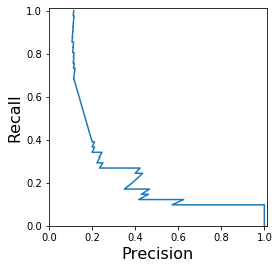

/home/plian/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


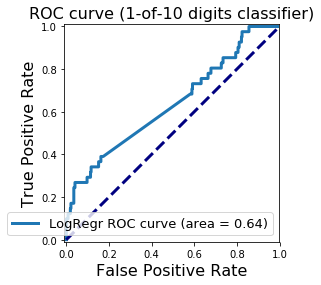

In [312]:
import matplotlib.pyplot as plt
#print(precision, recall, thresholds)
#print(fpr, tpr, _ )

plt.figure()
plt.xlim([0.0, 1.01])
plt.ylim([0.0, 1.01])
plt.plot(precision, recall, label='Precision-Recall Curve')
#plt.plot(closest_zero_p, closest_zero_r, 'o', markersize = 12, fillstyle = 'none', c='r', mew=3)
plt.xlabel('Precision', fontsize=16)
plt.ylabel('Recall', fontsize=16)
plt.axes().set_aspect('equal')
plt.show()

plt.figure()
plt.xlim([-0.01, 1.00])
plt.ylim([-0.01, 1.01])
plt.plot(fpr, tpr, lw=3, label='LogRegr ROC curve (area = {:0.2f})'.format(roc_auc))
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve (1-of-10 digits classifier)', fontsize=16)
plt.legend(loc='lower right', fontsize=13)
plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
plt.axes().set_aspect('equal')
plt.show()